# Multimodal data fusion and defect classification
- Experiment data: June 2022. Maraging Steel 300
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial ccd features, acoustic feature, thermal features
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 6: Inference and visualization

## System setup

In [1]:
from sklearnex import patch_sklearn, config_context
import dpctl
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import taichi as ti
ti.init(arch=ti.gpu)

[Taichi] version 1.3.0, llvm 15.0.1, commit 0f25b95e, win, python 3.8.12
[Taichi] Starting on arch=cuda


In [3]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import itertools
from pandas import DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

# For data standardization (transformation of the data onto unit scale (mean=0 and variance=1), required in most machine learning)
from sklearn.preprocessing import StandardScaler
# For K Nearest Neighbours:
from sklearn import neighbors
# For support vector machine:
from sklearn import svm
# For Gaussian process:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
# For neural network:
from sklearn.neural_network import MLPClassifier
# For decision tree:
from sklearn import tree
# For plotting the decision tree structure:
import graphviz
import pickle
# For ensemble methods: random forest ad AdaBoost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# For Naive Bayes method:
from sklearn.naive_bayes import GaussianNB
# For logistic regression:
from sklearn.linear_model import LogisticRegression
# For data standardization (transform the data so that they have a near-normally distribution with zero mean and unit variance)
from sklearn import preprocessing

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from pprint import pprint
from scipy.interpolate import griddata
from pylab import * # For adjusting frame width only
from sklearn.preprocessing import OneHotEncoder
import sklearn.gaussian_process as gp 
import sklearn.model_selection as ms
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import svm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_digits
# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split  # random split the data into "training data" and "testing data"
from sklearn.model_selection import GridSearchCV  # Exhaustive grid search with cross validation (CV)
from sklearn import metrics
from sklearn.metrics import classification_report

In [4]:
import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_utils

In [5]:
# For plotting
import plotly.io as pio
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt

# For ML model saving
import pickle
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white", palette=None)

In [6]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [7]:
import sys
sys.path.insert(0, '../utils')
import glob
import os
# import utils
FRAME_SIZE = 2048
HOP_LENGTH = 512

In [8]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"

Audio_ROOT = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\LDED_audio_dataset")
             
Audio_PATH_original = os.path.join(Audio_ROOT, 'wave_file', "original")
Audio_PATH_equalized = os.path.join(Audio_ROOT, 'wave_file', "equalized")
Audio_PATH_bandpassed = os.path.join(Audio_ROOT, 'wave_file', "bandpassed")
Audio_PATH_denoised = os.path.join(Audio_ROOT, 'wave_file', "denoised",)


Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring")
Audio_extracted_feature_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\Acoustic_feature")
Raw_experiment_csv_PATH = os.path.join(Multimodal_dataset_PATH, "Raw_multisensor_feature")
Thermal_feature_csv_PATH = os.path.join(Multimodal_dataset_PATH, "Thermal_feature")
Spatiotemporal_registered_PATH = os.path.join(Multimodal_dataset_PATH, "Spatiotemporal_registered")
Multisensor_fused_PATH = os.path.join(Multimodal_dataset_PATH, "Multisensor_fused")
ML_model_PATH = os.path.join(PROJECT_ROOT_DIR, 'trained_models', '40ms')
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'ML_results', 'prediction','40ms')
HTML_PATH = os.path.join(PROJECT_ROOT_DIR, "html", 'multimodal_experiment', "prediction", '40ms')

os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(HTML_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Import Extracted features

## Load single experiment files with ground truth labels

### Load dataset, pre-processing

In [9]:
dataset_21_file = os.path.join(Spatiotemporal_registered_PATH, "sample_21_resampled.csv")
dataset_22_file = os.path.join(Spatiotemporal_registered_PATH, "sample_22_resampled.csv")
dataset_23_file = os.path.join(Spatiotemporal_registered_PATH, "sample_23_resampled.csv")
dataset_24_file = os.path.join(Spatiotemporal_registered_PATH, "sample_24_resampled.csv")
dataset_26_file = os.path.join(Spatiotemporal_registered_PATH, "sample_26_resampled.csv")
label_file = os.path.join(Multimodal_dataset_PATH, 'label.csv')

In [10]:
# dropna, create pandas dataframe
labels = pd.read_csv(label_file).dropna(axis=0)

def reset_dataset(dataset_filename):
    dataset = pd.read_csv(dataset_filename).dropna(axis=0)
    # dataset = dataset[dataset.layer != 0] # remove all the '0' layer
    # resetting the DataFrame index
    dataset = dataset.reset_index()
    return dataset

In [11]:
dataset_21 = reset_dataset(dataset_21_file)
dataset_22 = reset_dataset(dataset_22_file)
dataset_23 = reset_dataset(dataset_23_file)
dataset_24 = reset_dataset(dataset_24_file)
dataset_26 = reset_dataset(dataset_26_file)

<AxesSubplot:>

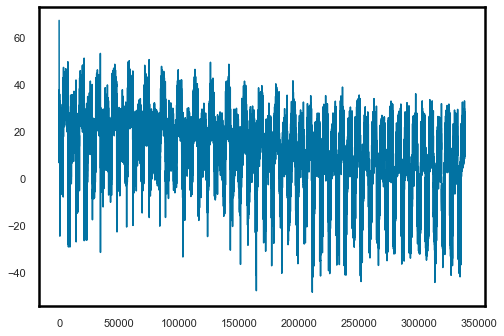

In [12]:
dataset_23['MFCC3'].plot()

In [13]:
labels.head()

Sample  layer  label        Label
0      25     -1      0    Laser-off
1      25      1      1  Defect-free
2      25      2      1  Defect-free
3      25      3      1  Defect-free
4      25      4      1  Defect-free

In [14]:
feature_list = ["X", "Y", 'Z', 'Peak temperature','Mean temperature', 'Temperature std', 'Temperature variance',
               'Convex hull area', 'Max contour area', 'Ellipse width',
               'Ellipse length', 'Rectangle length', 'Rectangle width', 'Mu20', 'Mu11',
               'Mu02', 'Mu30', 'Mu21', 'Mu12', 'Mu03', 'RMS energy',
               'Amplitude envelope', 'ZCR', 'MFCC0', 'MFCC1', 'MFCC2', 'MFCC3',
               'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8', 'MFCC9', 'MFCC10',
               'MFCC11', 'MFCC12', 'Spectral centroid', 'Spectral bandwidth',
               'Spectral rolloff', 'Spectral flatness', 'Spectral kurtosis',
               'Spectral variance', 'Spectral crest', 'Spectral skewness',
               'Spectral entropy', 'Spectral contrast', 'Spectral flux', 'layer', 'Sample']


In [15]:
def get_truncated_multimodal_dataset(df_dataset, df_label, interval=20):
    df_dataset_mean = (df_dataset.groupby(np.arange(len(df_dataset)) // interval).transform('mean')).drop_duplicates().reset_index()
    # df_dataset_mean = df_dataset_mean.drop(['level_0', 'index'], axis=1)
    df_dataset_mean = df_dataset_mean.astype({"layer":"int"})
    
    # df_dataset_truncated = df_dataset_mean
    df_multimodal_dataset = df_dataset_mean.merge(df_label, how='left', on=['layer', 'Sample'])
    return df_multimodal_dataset

In [16]:
# df_multimodal_21 = get_truncated_multimodal_dataset(dataset_21[feature_list], labels, interval=3) #x30 - 40ms; 100- 133ms; 300 - 400s; 75 - 100s; 375-500ms
# df_multimodal_22 = get_truncated_multimodal_dataset(dataset_22[feature_list], labels, interval=3)
# df_multimodal_23 = get_truncated_multimodal_dataset(dataset_23[feature_list], labels, interval=3)
# df_multimodal_24 = get_truncated_multimodal_dataset(dataset_24[feature_list], labels, interval=3)
# df_multimodal_26 = get_truncated_multimodal_dataset(dataset_26[feature_list], labels, interval=3)

# df_multimodal_21 = dataset_21[feature_list].merge(labels, how='left', on=['layer', 'Sample'])
# df_multimodal_22 = dataset_22[feature_list].merge(labels, how='left', on=['layer', 'Sample'])
# df_multimodal_23 = dataset_23[feature_list].merge(labels, how='left', on=['layer', 'Sample'])
# df_multimodal_24 = dataset_24[feature_list].merge(labels, how='left', on=['layer', 'Sample'])
# df_multimodal_26 = dataset_26[feature_list].merge(labels, how='left', on=['layer', 'Sample'])

df_multimodal_21 = dataset_21[feature_list]
df_multimodal_22 = dataset_22[feature_list]
df_multimodal_23 = dataset_23[feature_list]
df_multimodal_24 = dataset_24[feature_list]
df_multimodal_26 = dataset_26[feature_list]

<AxesSubplot:>

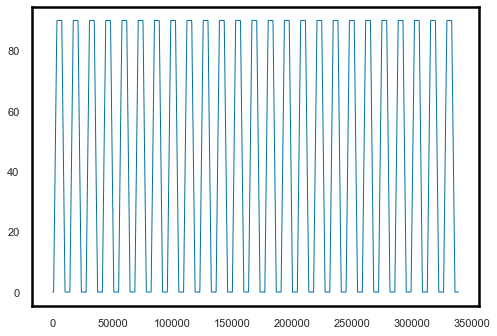

In [17]:
dataset_23['X'].plot(linewidth=1)

In [18]:
print (len(df_multimodal_22.columns))
df_multimodal_22.columns

49


Index(['X', 'Y', 'Z', 'Peak temperature', 'Mean temperature',
       'Temperature std', 'Temperature variance', 'Convex hull area',
       'Max contour area', 'Ellipse width', 'Ellipse length',
       'Rectangle length', 'Rectangle width', 'Mu20', 'Mu11', 'Mu02', 'Mu30',
       'Mu21', 'Mu12', 'Mu03', 'RMS energy', 'Amplitude envelope', 'ZCR',
       'MFCC0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7',
       'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12', 'Spectral centroid',
       'Spectral bandwidth', 'Spectral rolloff', 'Spectral flatness',
       'Spectral kurtosis', 'Spectral variance', 'Spectral crest',
       'Spectral skewness', 'Spectral entropy', 'Spectral contrast',
       'Spectral flux', 'layer', 'Sample'],
      dtype='object')

### Data Standarization (zero mean and unit variance)

In [19]:
from sklearn.preprocessing import StandardScaler

numeric_list = ["X", "Y", 'Z','Peak temperature','Mean temperature', 'Temperature std', 'Temperature variance',
               'Convex hull area', 'Max contour area', 'Ellipse width',
               'Ellipse length', 'Rectangle length', 'Rectangle width', 'Mu20', 'Mu11',
               'Mu02', 'Mu30', 'Mu21', 'Mu12', 'Mu03', 'RMS energy',
               'Amplitude envelope', 'ZCR', 'MFCC0', 'MFCC1', 'MFCC2', 'MFCC3',
               'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8', 'MFCC9', 'MFCC10',
               'MFCC11', 'MFCC12', 'Spectral centroid', 'Spectral bandwidth',
               'Spectral rolloff', 'Spectral flatness', 'Spectral kurtosis',
               'Spectral variance', 'Spectral crest', 'Spectral skewness',
               'Spectral entropy', 'Spectral contrast', 'Spectral flux'] #, 'label', "Label"

file_name_prefix = "sample 22 "
df_selected = df_multimodal_22[numeric_list].dropna()
df_selected = df_selected.reset_index(drop=True)

In [20]:
df_selected

X         Y          Z  Peak temperature  Mean temperature  \
0       0.009277  0.300782   0.060303        393.720000        391.830000   
1       0.009562  0.301107   0.060262        393.727467        391.830373   
2       0.009847  0.301433   0.060221        393.734933        391.830747   
3       0.010131  0.301758   0.060181        393.742400        391.831120   
4       0.010449  0.302084   0.060071        393.749866        391.831493   
...          ...       ...        ...               ...               ...   
138895  0.052905  0.274726  19.694620       1967.973585       1227.749862   
138896  0.052563  0.274577  19.694744       1973.301403       1227.889839   
138897  0.052221  0.274435  19.694870       1977.897908       1228.030712   
138898  0.051879  0.274298  19.694998       1981.763099       1228.172482   
138899  0.051546  0.274178  19.695113       1984.896976       1228.315147   

        Temperature std  Temperature variance  Convex hull area  \
0              0.650000              4.410000               0.0   
1              0.650000              4.417467               0.0   
2              0.650000              4.424933               0.0   
3              0.650000              4.432400               0.0   
4              0.650000              4.439866               0.0   
...                 ...                   ...               ...   
138895       367.341144           1568.438294               0.0   
138896       367.321174           1573.776513               0.0   
138897       367.299784           1578.382337               0.0   
138898       367.276976           1582.255763               0.0   
138899       367.252750           1585.396793               0.0   

        Max contour area  Ellipse width  ...  Spectral bandwidth  \
0               0.000000       0.000000  ...         3051.948693   
1               0.000000       0.000000  ...         3019.580393   
2               0.000000       0.000000  ...         2987.212093   
3               0.000000       0.000000  ...         2954.843793   
4               0.000000       0.000000  ...         2922.475493   
...                  ...            ...  ...                 ...   
138895      44164.292162     225.318897  ...         3371.368388   
138896      43954.728378     224.999158  ...         3380.498607   
138897      43745.164594     224.679420  ...         3390.264697   
138898      43535.600811     224.359681  ...         3400.666659   
138899      43326.037027     224.039943  ...         3411.704492   

        Spectral rolloff  Spectral flatness  Spectral kurtosis  \
0            9905.273438           0.016614          32.798008   
1            9890.438209           0.016174          32.245768   
2            9875.602981           0.015735          31.693527   
3            9860.767753           0.015295          31.141287   
4            9845.932525           0.014856          30.589046   
...                  ...                ...                ...   
138895      10193.748349           0.023451           9.963569   
138896      10193.010231           0.023634           9.587626   
138897      10198.206204           0.023781           9.243955   
138898      10209.336268           0.023895           8.932556   
138899      10226.400423           0.023974           8.653429   

        Spectral variance  Spectral crest  Spectral skewness  \
0                2.288251    1.379098e-06           4.900886   
1                2.274415    1.366375e-06           4.858422   
2                2.260578    1.353652e-06           4.815958   
3                2.246741    1.340930e-06           4.773494   
4                2.232905    1.328207e-06           4.731030   
...                   ...             ...                ...   
138895           1.464946    6.472948e-07           2.777866   
138896           1.460241    6.379546e-07           2.739915   
138897           1.455577    6.283004e-07           2.704270   
138898           1.450954    6.1833

In [21]:
# Label = df_selected['Label'].to_list()
# y = df_selected['label'].to_list()

#removed: 'Mu11 mean', 'Mu30 mean', 'Mu21 mean', 'Mu12 mean','RMS energy mean', 'Amplitude envelope mean','ZCR mean', 'MFCC4 mean', 'MFCC7 mean',
#'MFCC9 mean', 'MFCC10 mean', 'MFCC11 mean', 'MFCC12 mean', 'Spectral rolloff mean','Spectral kurtosis mean','Spectral crest mean','Spectral contrast mean',
X_all = df_selected[['Peak temperature', 'Mean temperature',
                       'Temperature std', 'Temperature variance',
                       'Convex hull area', 'Max contour area', 'Ellipse width',
                       'Ellipse length', 'Rectangle length', 'Rectangle width',
                       'Mu20', 'Mu02', 'Mu03', 
                       'MFCC0', 'MFCC1', 'MFCC2', 'MFCC3',
                       'MFCC5', 'MFCC6', 'MFCC8',
                       'Spectral centroid', 'Spectral bandwidth',
                       'Spectral flatness', 'Spectral variance', 'Spectral skewness',
                       'Spectral entropy', 'Spectral flux']].to_numpy()
              

X_acoustic = df_selected[[ 'MFCC0', 'MFCC1', 'MFCC2', 'MFCC3',
                           'MFCC5', 'MFCC6', 'MFCC8',
                           'Spectral centroid', 'Spectral bandwidth',
                           'Spectral flatness', 'Spectral variance', 'Spectral skewness',
                           'Spectral entropy', 'Spectral flux']].to_numpy()
                      

X_vision = df_selected[['Convex hull area', 'Max contour area', 'Ellipse width',
                       'Ellipse length', 'Rectangle length', 'Rectangle width',
                       'Mu20', 'Mu02', 'Mu03']].to_numpy() 


X_thermal = df_selected[[ 'Peak temperature', 'Mean temperature',
                       'Temperature std', 'Temperature variance']].to_numpy()

In [22]:
scaler = preprocessing.StandardScaler() 

X_all_transformed = scaler.fit_transform(X_all)

X_acoustic_transformed = scaler.fit_transform(X_acoustic)

X_vision_transformed = scaler.fit_transform(X_vision)

X_thermal_transformed = scaler.fit_transform(X_thermal)

## Load the trained models to make a prediction

In [23]:
# Save Model Using Pickle
# ["KNN","DT", "LR", "SVC","GB", "RF" ]
metamodel_KNN_all_file = os.path.join(ML_model_PATH, 'metamodel_KNN_all_40ms.sav')
metamodel_DT_all_file = os.path.join(ML_model_PATH, 'metamodel_DT_all_40ms.sav')
metamodel_LR_all_file = os.path.join(ML_model_PATH, 'metamodel_LR_all_40ms.sav')
metamodel_SVC_all_file = os.path.join(ML_model_PATH, 'metamodel_SVC_all_40ms.sav')
metamodel_GB_all_file = os.path.join(ML_model_PATH, 'metamodel_GB_all_40ms.sav')
metamodel_RF_all_file = os.path.join(ML_model_PATH, 'metamodel_RF_all_40ms.sav')
metamodel_NN_all_file = os.path.join(ML_model_PATH, 'metamodel_NN_all_40ms.sav')

metamodel_KNN_vision_file = os.path.join(ML_model_PATH, 'metamodel_KNN_vision_40ms.sav')
metamodel_DT_vision_file = os.path.join(ML_model_PATH, 'metamodel_DT_vision_40ms.sav')
metamodel_LR_vision_file = os.path.join(ML_model_PATH, 'metamodel_LR_vision_40ms.sav')
metamodel_SVC_vision_file = os.path.join(ML_model_PATH, 'metamodel_SVC_vision_40ms.sav')
metamodel_GB_vision_file = os.path.join(ML_model_PATH, 'metamodel_GB_vision_40ms.sav')
metamodel_RF_vision_file = os.path.join(ML_model_PATH, 'metamodel_RF_vision_40ms.sav')
metamodel_NN_vision_file = os.path.join(ML_model_PATH, 'metamodel_NN_vision_40ms.sav')

metamodel_KNN_acoustic_file = os.path.join(ML_model_PATH, 'metamodel_KNN_acoustic_40ms.sav')
metamodel_DT_acoustic_file = os.path.join(ML_model_PATH, 'metamodel_DT_acoustic_40ms.sav')
metamodel_LR_acoustic_file = os.path.join(ML_model_PATH, 'metamodel_LR_acoustic_40ms.sav')
metamodel_SVC_acoustic_file = os.path.join(ML_model_PATH, 'metamodel_SVC_acoustic_40ms.sav')
metamodel_GB_acoustic_file = os.path.join(ML_model_PATH, 'metamodel_GB_acoustic_40ms.sav')
metamodel_RF_acoustic_file = os.path.join(ML_model_PATH, 'metamodel_RF_acoustic_40ms.sav')
metamodel_NN_acoustic_file = os.path.join(ML_model_PATH, 'metamodel_NN_acoustic_40ms.sav')

metamodel_KNN_thermal_file = os.path.join(ML_model_PATH, 'metamodel_KNN_thermal_40ms.sav')
metamodel_DT_thermal_file = os.path.join(ML_model_PATH, 'metamodel_DT_thermal_40ms.sav')
metamodel_LR_thermal_file = os.path.join(ML_model_PATH, 'metamodel_LR_thermal_40ms.sav')
metamodel_SVC_thermal_file = os.path.join(ML_model_PATH, 'metamodel_SVC_thermal_40ms.sav')
metamodel_GB_thermal_file = os.path.join(ML_model_PATH, 'metamodel_GB_thermal_40ms.sav')
metamodel_RF_thermal_file = os.path.join(ML_model_PATH, 'metamodel_RF_thermal_40ms.sav')
metamodel_NN_thermal_file = os.path.join(ML_model_PATH, 'metamodel_NN_thermal_40ms.sav')

### Prediction -- all features

In [24]:
for modeltoggle in ["NN",'SVC',"RF", "GB","KNN","DT", 'LR']:
    
    if modeltoggle == 'RF':
        model = pickle.load(open(metamodel_RF_all_file, 'rb'))
    elif modeltoggle == 'KNN':
        mmodel = pickle.load(open(metamodel_KNN_all_file, 'rb'))
    elif modeltoggle == 'DT':
        model = pickle.load(open(metamodel_DT_all_file, 'rb'))
    elif modeltoggle == 'SVC':
        model = pickle.load(open(metamodel_SVC_all_file, 'rb'))
    elif modeltoggle == 'GB':
        model = pickle.load(open(metamodel_GB_all_file, 'rb'))
    elif modeltoggle == 'NN':
        model = pickle.load(open(metamodel_NN_all_file, 'rb'))
    elif modeltoggle == 'LR':
        model = pickle.load(open(metamodel_LR_all_file, 'rb'))
        
    
    # score = model.score(X_all_transformed, y)
    # print ("Score of " + modeltoggle + " on all features: " + str(score))
    
    Y_predicted = model.predict(X_all_transformed)
    list_name = "Y_predicted_all_" + modeltoggle
    df_selected[list_name] = Y_predicted
    
df_selected.head()

X         Y         Z  Peak temperature  Mean temperature  \
0  0.009277  0.300782  0.060303        393.720000        391.830000   
1  0.009562  0.301107  0.060262        393.727467        391.830373   
2  0.009847  0.301433  0.060221        393.734933        391.830747   
3  0.010131  0.301758  0.060181        393.742400        391.831120   
4  0.010449  0.302084  0.060071        393.749866        391.831493   

   Temperature std  Temperature variance  Convex hull area  Max contour area  \
0             0.65              4.410000               0.0               0.0   
1             0.65              4.417467               0.0               0.0   
2             0.65              4.424933               0.0               0.0   
3             0.65              4.432400               0.0               0.0   
4             0.65              4.439866               0.0               0.0   

   Ellipse width  ...  Spectral entropy  Spectral contrast  Spectral flux  \
0            0.0  ...          0.831966           0.540705       0.000000   
1            0.0  ...          0.831504           1.522744       0.000178   
2            0.0  ...          0.831041           2.504783       0.000355   
3            0.0  ...          0.830579           3.486823       0.000533   
4            0.0  ...          0.830116           4.468862       0.000710   

   Y_predicted_all_NN  Y_predicted_all_SVC  Y_predicted_all_RF  \
0                   0                    0                   0   
1                   0                    0                   0   
2                   0                    0                   0   
3                   0                    0                   0   
4                   0                    0                   0   

   Y_predicted_all_GB  Y_predicted_all_KNN  Y_predicted_all_DT  \
0                   0                    0                   0   
1                   0                    0                   0   
2                   0                    0                   0   
3                   0                    0                   0   
4                   0                    0                   0   

   Y_predicted_all_LR  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 54 columns]

### Prediction -- vision features

In [25]:
for modeltoggle in ["NN",'SVC',"RF", "GB","KNN","DT", 'LR']:
    
    if modeltoggle == 'RF':
        model = pickle.load(open(metamodel_RF_vision_file, 'rb'))
    elif modeltoggle == 'KNN':
        mmodel = pickle.load(open(metamodel_KNN_vision_file, 'rb'))
    elif modeltoggle == 'DT':
        model = pickle.load(open(metamodel_DT_vision_file, 'rb'))
    elif modeltoggle == 'SVC':
        model = pickle.load(open(metamodel_SVC_vision_file, 'rb'))
    elif modeltoggle == 'GB':
        model = pickle.load(open(metamodel_GB_vision_file, 'rb'))
    elif modeltoggle == 'NN':
        model = pickle.load(open(metamodel_NN_vision_file, 'rb'))
    elif modeltoggle == 'LR':
        model = pickle.load(open(metamodel_LR_vision_file, 'rb'))
        
    
    # score = model.score(X_vision_transformed, y)
    # print ("Score of " + modeltoggle + " on vision features: " + str(score))
    
    Y_predicted = model.predict(X_vision_transformed)
    list_name = "Y_predicted_vision_" + modeltoggle
    df_selected[list_name] = Y_predicted
    
df_selected.head()

X         Y         Z  Peak temperature  Mean temperature  \
0  0.009277  0.300782  0.060303        393.720000        391.830000   
1  0.009562  0.301107  0.060262        393.727467        391.830373   
2  0.009847  0.301433  0.060221        393.734933        391.830747   
3  0.010131  0.301758  0.060181        393.742400        391.831120   
4  0.010449  0.302084  0.060071        393.749866        391.831493   

   Temperature std  Temperature variance  Convex hull area  Max contour area  \
0             0.65              4.410000               0.0               0.0   
1             0.65              4.417467               0.0               0.0   
2             0.65              4.424933               0.0               0.0   
3             0.65              4.432400               0.0               0.0   
4             0.65              4.439866               0.0               0.0   

   Ellipse width  ...  Y_predicted_all_KNN  Y_predicted_all_DT  \
0            0.0  ...                    0                   0   
1            0.0  ...                    0                   0   
2            0.0  ...                    0                   0   
3            0.0  ...                    0                   0   
4            0.0  ...                    0                   0   

   Y_predicted_all_LR  Y_predicted_vision_NN  Y_predicted_vision_SVC  \
0                   0                      0                       0   
1                   0                      0                       0   
2                   0                      0                       0   
3                   0                      0                       0   
4                   0                      0                       0   

   Y_predicted_vision_RF  Y_predicted_vision_GB  Y_predicted_vision_KNN  \
0                      0                      0                       0   
1                      0                      0                       0   
2                      0                      0                       0   
3                      0                      0                       0   
4                      0                      0                       0   

   Y_predicted_vision_DT  Y_predicted_vision_LR  
0                      0                      0  
1                      0                      0  
2                      0                      0  
3                      0                      0  
4                      0                      0  

[5 rows x 61 columns]

### Prediction -- acoustic features

In [26]:
for modeltoggle in ["NN",'SVC',"RF", "GB","KNN","DT", 'LR']:
    
    if modeltoggle == 'RF':
        model = pickle.load(open(metamodel_RF_acoustic_file, 'rb'))
    elif modeltoggle == 'KNN':
        mmodel = pickle.load(open(metamodel_KNN_acoustic_file, 'rb'))
    elif modeltoggle == 'DT':
        model = pickle.load(open(metamodel_DT_acoustic_file, 'rb'))
    elif modeltoggle == 'SVC':
        model = pickle.load(open(metamodel_SVC_acoustic_file, 'rb'))
    elif modeltoggle == 'GB':
        model = pickle.load(open(metamodel_GB_acoustic_file, 'rb'))
    elif modeltoggle == 'NN':
        model = pickle.load(open(metamodel_NN_acoustic_file, 'rb'))
    elif modeltoggle == 'LR':
        model = pickle.load(open(metamodel_LR_acoustic_file, 'rb'))
        
    
    # score = model.score(X_acoustic_transformed, y)
    # print ("Score of " + modeltoggle + " on acoustic features: " + str(score))
    
    Y_predicted = model.predict(X_acoustic_transformed)
    list_name = "Y_predicted_acoustic_" + modeltoggle
    df_selected[list_name] = Y_predicted
    
df_selected.head()

X         Y         Z  Peak temperature  Mean temperature  \
0  0.009277  0.300782  0.060303        393.720000        391.830000   
1  0.009562  0.301107  0.060262        393.727467        391.830373   
2  0.009847  0.301433  0.060221        393.734933        391.830747   
3  0.010131  0.301758  0.060181        393.742400        391.831120   
4  0.010449  0.302084  0.060071        393.749866        391.831493   

   Temperature std  Temperature variance  Convex hull area  Max contour area  \
0             0.65              4.410000               0.0               0.0   
1             0.65              4.417467               0.0               0.0   
2             0.65              4.424933               0.0               0.0   
3             0.65              4.432400               0.0               0.0   
4             0.65              4.439866               0.0               0.0   

   Ellipse width  ...  Y_predicted_vision_KNN  Y_predicted_vision_DT  \
0            0.0  ...                       0                      0   
1            0.0  ...                       0                      0   
2            0.0  ...                       0                      0   
3            0.0  ...                       0                      0   
4            0.0  ...                       0                      0   

   Y_predicted_vision_LR  Y_predicted_acoustic_NN  Y_predicted_acoustic_SVC  \
0                      0                        3                         3   
1                      0                        3                         3   
2                      0                        3                         3   
3                      0                        3                         3   
4                      0                        3                         3   

   Y_predicted_acoustic_RF  Y_predicted_acoustic_GB  Y_predicted_acoustic_KNN  \
0                        2                        2                         2   
1                        1                        2                         2   
2                        1                        2                         2   
3                        1                        2                         2   
4                        1                        2                         2   

   Y_predicted_acoustic_DT  Y_predicted_acoustic_LR  
0                        0                        3  
1                        0                        3  
2                        0                        3  
3                        0                        3  
4                        0                        3  

[5 rows x 68 columns]

### Prediction -- thermal features

In [27]:
for modeltoggle in ["NN",'SVC',"RF", "GB","KNN","DT", 'LR']:
    
    if modeltoggle == 'RF':
        model = pickle.load(open(metamodel_RF_thermal_file, 'rb'))
    elif modeltoggle == 'KNN':
        mmodel = pickle.load(open(metamodel_KNN_thermal_file, 'rb'))
    elif modeltoggle == 'DT':
        model = pickle.load(open(metamodel_DT_thermal_file, 'rb'))
    elif modeltoggle == 'SVC':
        model = pickle.load(open(metamodel_SVC_thermal_file, 'rb'))
    elif modeltoggle == 'GB':
        model = pickle.load(open(metamodel_GB_thermal_file, 'rb'))
    elif modeltoggle == 'NN':
        model = pickle.load(open(metamodel_NN_thermal_file, 'rb'))
    elif modeltoggle == 'LR':
        model = pickle.load(open(metamodel_LR_thermal_file, 'rb'))
        
    
    # score = model.score(X_thermal_transformed, y)
    # print ("Score of " + modeltoggle + " on thermal features: " + str(score))
    
    Y_predicted = model.predict(X_thermal_transformed)
    list_name = "Y_predicted_thermal_" + modeltoggle
    df_selected[list_name] = Y_predicted
    
df_selected.head()

X         Y         Z  Peak temperature  Mean temperature  \
0  0.009277  0.300782  0.060303        393.720000        391.830000   
1  0.009562  0.301107  0.060262        393.727467        391.830373   
2  0.009847  0.301433  0.060221        393.734933        391.830747   
3  0.010131  0.301758  0.060181        393.742400        391.831120   
4  0.010449  0.302084  0.060071        393.749866        391.831493   

   Temperature std  Temperature variance  Convex hull area  Max contour area  \
0             0.65              4.410000               0.0               0.0   
1             0.65              4.417467               0.0               0.0   
2             0.65              4.424933               0.0               0.0   
3             0.65              4.432400               0.0               0.0   
4             0.65              4.439866               0.0               0.0   

   Ellipse width  ...  Y_predicted_acoustic_KNN  Y_predicted_acoustic_DT  \
0            0.0  ...                         2                        0   
1            0.0  ...                         2                        0   
2            0.0  ...                         2                        0   
3            0.0  ...                         2                        0   
4            0.0  ...                         2                        0   

   Y_predicted_acoustic_LR  Y_predicted_thermal_NN  Y_predicted_thermal_SVC  \
0                        3                       0                        0   
1                        3                       0                        0   
2                        3                       0                        0   
3                        3                       0                        0   
4                        3                       0                        0   

   Y_predicted_thermal_RF  Y_predicted_thermal_GB  Y_predicted_thermal_KNN  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       0                        0   

   Y_predicted_thermal_DT  Y_predicted_thermal_LR  
0                       0                       0  
1                       0                       0  
2                       0                       0  
3                       0                       0  
4                       0                       0  

[5 rows x 75 columns]

In [28]:
df_selected

X         Y          Z  Peak temperature  Mean temperature  \
0       0.009277  0.300782   0.060303        393.720000        391.830000   
1       0.009562  0.301107   0.060262        393.727467        391.830373   
2       0.009847  0.301433   0.060221        393.734933        391.830747   
3       0.010131  0.301758   0.060181        393.742400        391.831120   
4       0.010449  0.302084   0.060071        393.749866        391.831493   
...          ...       ...        ...               ...               ...   
138895  0.052905  0.274726  19.694620       1967.973585       1227.749862   
138896  0.052563  0.274577  19.694744       1973.301403       1227.889839   
138897  0.052221  0.274435  19.694870       1977.897908       1228.030712   
138898  0.051879  0.274298  19.694998       1981.763099       1228.172482   
138899  0.051546  0.274178  19.695113       1984.896976       1228.315147   

        Temperature std  Temperature variance  Convex hull area  \
0              0.650000              4.410000               0.0   
1              0.650000              4.417467               0.0   
2              0.650000              4.424933               0.0   
3              0.650000              4.432400               0.0   
4              0.650000              4.439866               0.0   
...                 ...                   ...               ...   
138895       367.341144           1568.438294               0.0   
138896       367.321174           1573.776513               0.0   
138897       367.299784           1578.382337               0.0   
138898       367.276976           1582.255763               0.0   
138899       367.252750           1585.396793               0.0   

        Max contour area  Ellipse width  ...  Y_predicted_acoustic_KNN  \
0               0.000000       0.000000  ...                         2   
1               0.000000       0.000000  ...                         2   
2               0.000000       0.000000  ...                         2   
3               0.000000       0.000000  ...                         2   
4               0.000000       0.000000  ...                         2   
...                  ...            ...  ...                       ...   
138895      44164.292162     225.318897  ...                         3   
138896      43954.728378     224.999158  ...                         3   
138897      43745.164594     224.679420  ...                         3   
138898      43535.600811     224.359681  ...                         3   
138899      43326.037027     224.039943  ...                         3   

        Y_predicted_acoustic_DT  Y_predicted_acoustic_LR  \
0                             0                        3   
1                             0                        3   
2                             0                        3   
3                             0                        3   
4                             0                        3   
...                         ...                      ...   
138895                        3                        3   
138896                        3                        3   
138897                        3                        3   
138898                        3                        3   
138899                        3                        3   

        Y_predicted_thermal_NN  Y_predicted_thermal_SVC  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
138895                       0                        3   
138896                       0                        3   
138897                       0                        3   
138898                       0                        3   
138899                    

<AxesSubplot:>

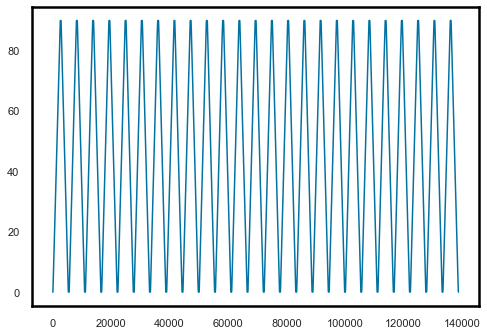

In [29]:
df_selected['X'].plot()

In [30]:
len(df_selected)

138900

## Visualization

In [31]:
import plotly.express as px

def prediction_visualization_2D(file_name_prefix, ML_predictor ):
    df_selected[ML_predictor] = df_selected[ML_predictor].astype(str)
    fig = px.scatter(df_selected, x="X", y="Z", color=ML_predictor,
                     title="Predicted", color_discrete_sequence=[
                     'green', "blue", "orange", "red"],
                     category_orders={ # replaces default order by column name
                     ML_predictor: ["0", "1", "2", "3"]
                     },
                    )

    # fig.update_traces(marker=dict(size=10,
    #                               line=dict(width=0.1,
    #                                         color='DarkSlateGrey')),
    #                   selector=dict(mode='markers'))

    config = {
                  'toImageButtonOptions': {
                    'format': 'svg', # one of png, svg, jpeg, webp
                    'filename': 'custom_image',
                    # 'height': 700,
                    # 'width': 900,
                    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
                  }
             }

    # fig.show()
    pio.write_html(fig, os.path.join(HTML_PATH, "2D_" + file_name_prefix + ML_predictor + ".html"), auto_open=True, config=config)

In [32]:
prediction_visualization_2D(file_name_prefix, "Y_predicted_all_NN")
prediction_visualization_2D(file_name_prefix, "Y_predicted_acoustic_NN")
prediction_visualization_2D(file_name_prefix, "Y_predicted_vision_NN")
prediction_visualization_2D(file_name_prefix, "Y_predicted_thermal_NN")

prediction_visualization_2D(file_name_prefix, "Y_predicted_all_SVC")
prediction_visualization_2D(file_name_prefix, "Y_predicted_acoustic_SVC")
prediction_visualization_2D(file_name_prefix, "Y_predicted_vision_SVC")
prediction_visualization_2D(file_name_prefix, "Y_predicted_thermal_SVC")

prediction_visualization_2D(file_name_prefix, "Y_predicted_all_GB")
prediction_visualization_2D(file_name_prefix, "Y_predicted_acoustic_GB")
prediction_visualization_2D(file_name_prefix, "Y_predicted_vision_GB")
prediction_visualization_2D(file_name_prefix, "Y_predicted_thermal_GB")

prediction_visualization_2D(file_name_prefix, "Y_predicted_all_RF")
prediction_visualization_2D(file_name_prefix, "Y_predicted_acoustic_RF")
prediction_visualization_2D(file_name_prefix, "Y_predicted_vision_RF")
prediction_visualization_2D(file_name_prefix, "Y_predicted_thermal_RF")

In [33]:
import plotly.express as px

def spatial_feature_visualization(file_name_prefix, ML_predictor ):
    
    fig = px.scatter_3d(df_selected, x='X', y='Y', z='Z',
                        color=ML_predictor,
                       color_discrete_sequence=[
                     'green', "blue", "orange", "red"],
                     category_orders={ # replaces default order by column name
                     ML_predictor: ["0", "1", "2", "3"]
                     },
                    )

    angle = math.pi / 6 # 45 degrees
    camera = dict(
        # up=dict(x=0, y=math.sin(angle), z=math.sin(angle)),
        eye=dict(x=-1, y=2, z=0.9)
    )

    # https://plotly.com/python/reference/layout/xaxis/
    fig.update_layout(
        scene_camera=camera,
        title={
            'text': "Prediction",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        font = {
                'family': 'arial' ,
                'size': 14
            }

    )


    fig.update_layout(scene = dict(xaxis = dict(nticks=6, range=[-10,100]),
                                   zaxis = dict(nticks=3,range=[0, 21]), # for 2 [1225, 1235]
                                   yaxis = dict(nticks=6, range=[-2,2]),
                                   ))

    fig.update_traces(marker=dict(size=10,
                                  # line=dict(width=0.1,
                                            # color='DarkSlateGrey')
                     ),
                      selector=dict(mode='markers'))


    fig.update_layout(
                      # width=1300, 
                      # height=700,
                      margin=dict(l=5, r=5, b=5, t=5, pad=25),
                      scene = dict(xaxis = dict(nticks=6, range=[-10,100]),
                                   zaxis = dict(nticks=6,range=[0, 21]), # for 2 [1225, 1235]
                                   yaxis = dict(nticks=6, range=[-2,2]),
                                   xaxis_title= dict(text='X (mm)', font_size = 20),
                                   yaxis_title= dict(text='Y (mm)', font_size = 20),
                                   zaxis_title= dict(text='Z (mm)', font_size = 20)),
                                   )


    config = {
              'toImageButtonOptions': {
                'format': 'svg', # one of png, svg, jpeg, webp
                'filename': 'custom_image',
                # 'height': 700,
                # 'width': 900,
                'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
              }
            }

    # fig.show()
    pio.write_html(fig, os.path.join(HTML_PATH, file_name_prefix + ML_predictor + ".html"), auto_open=True, config=config)

In [34]:
spatial_feature_visualization(file_name_prefix, "Y_predicted_all_NN")
spatial_feature_visualization(file_name_prefix, "Y_predicted_acoustic_NN")
spatial_feature_visualization(file_name_prefix, "Y_predicted_vision_NN")
spatial_feature_visualization(file_name_prefix, "Y_predicted_thermal_NN")

spatial_feature_visualization(file_name_prefix, "Y_predicted_all_SVC")
spatial_feature_visualization(file_name_prefix, "Y_predicted_acoustic_SVC")
spatial_feature_visualization(file_name_prefix, "Y_predicted_vision_SVC")
spatial_feature_visualization(file_name_prefix, "Y_predicted_thermal_SVC")

spatial_feature_visualization(file_name_prefix, "Y_predicted_all_GB")
spatial_feature_visualization(file_name_prefix, "Y_predicted_acoustic_GB")
spatial_feature_visualization(file_name_prefix, "Y_predicted_vision_GB")
spatial_feature_visualization(file_name_prefix, "Y_predicted_thermal_GB")

spatial_feature_visualization(file_name_prefix, "Y_predicted_all_RF")
spatial_feature_visualization(file_name_prefix, "Y_predicted_acoustic_RF")
spatial_feature_visualization(file_name_prefix, "Y_predicted_vision_RF")
spatial_feature_visualization(file_name_prefix, "Y_predicted_thermal_RF")